In [ ]:
import pandas as pd
import numpy as np

import os
import scipy
import argparse

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.filters import uniform_filter1d
from scipy.signal import medfilt, savgol_filter, find_peaks_cwt
from sklearn.preprocessing import MinMaxScaler

from scipy.signal.wavelets import morlet

from pywt import dwt
import peakutils
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [12]:
# dataset = np.load('../features/raw_mean_std_normalized.npy')
dataset = np.load('../features/detrend_median41.npy')
# dataset = np.load('../features/detrend_gaussian10.npy')
# dataset = np.load('../features/')

In [8]:
dataset

array([[ -33.34,  -28.29,  -53.  , ...,    6.46,   16.  ,   19.93],
       [  96.08,   94.72,   57.28, ...,  -28.91,  -70.02,  -96.67],
       [  28.39,   45.04,   -8.79, ...,  -17.31,  -17.35,   13.98],
       ..., 
       [ 144.47,   20.09,  147.47, ..., -152.07, -216.6 , -202.97],
       [ 332.95,  284.55,  268.59, ..., -109.22, -103.7 ,  -93.28],
       [ -54.01,  -44.13,  -41.01, ...,    5.47,   14.46,   18.7 ]])

In [141]:
def smoothen(data):
#     return data
    return gaussian_filter(data, sigma=1)
#     return savgol_filter(data, polyorder=3, window_length=21)

def plot_peaks(index):
    series = dataset[index]
    smoothed = smoothen(series)
#     peaks = find_peaks_cwt(-smoothed, np.arange(1,200, 1))
    peaks = peakutils.indexes(-smoothed,thres=.2, min_dist=80)
    return peaks
#     plt.figure(figsize=(15,5))
#     plt.plot(series, 'o', markersize=3)
#     plt.plot(smoothed, 'o', markersize=3)
#     plt.plot(peaks, series[peaks], 'ro')
#     plt.title(index)
#     plt.show()
    
#     print peaks

In [142]:
 plot_peaks(4)

array([  30,  162,  272,  401,  485,  568,  706,  809,  925, 1038, 1134,
       1252, 1397, 1499, 1589, 1683, 1784, 1905, 2006, 2112, 2198, 2291,
       2382, 2463, 2558, 2718, 2826, 2933, 3065, 3150])

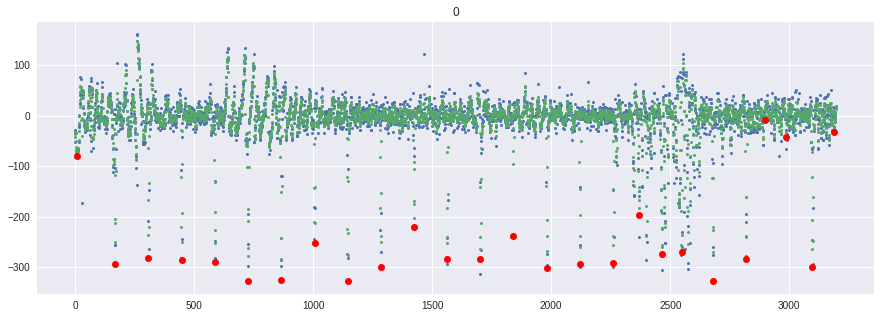

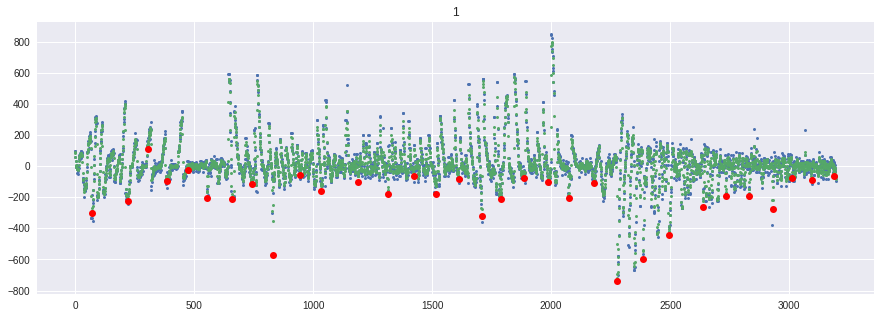

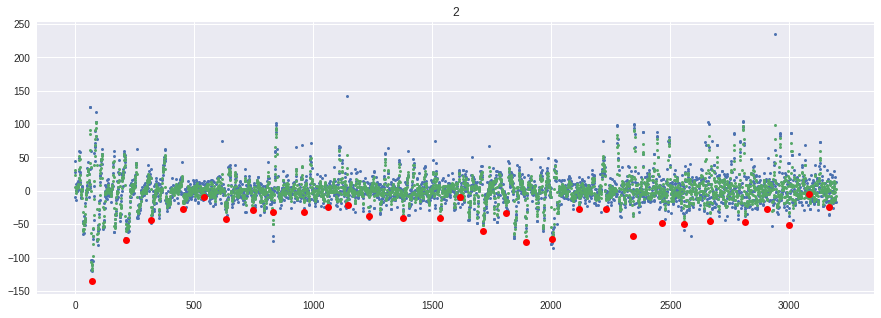

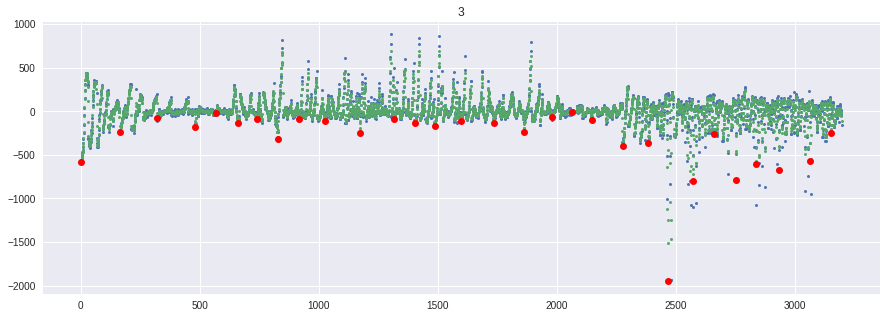

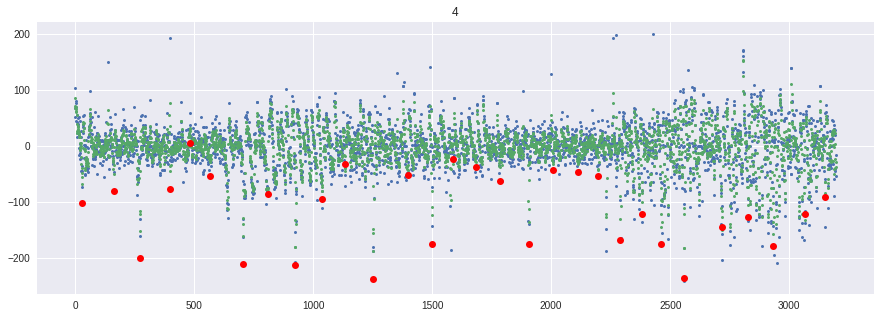

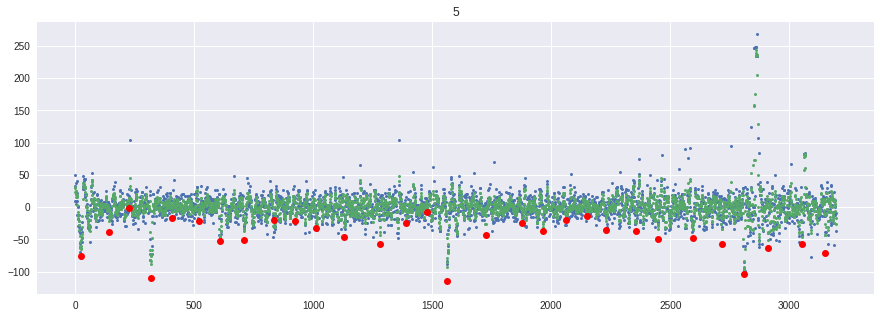

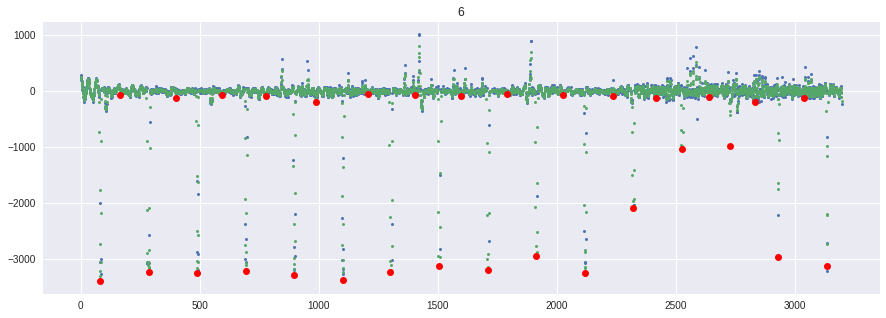

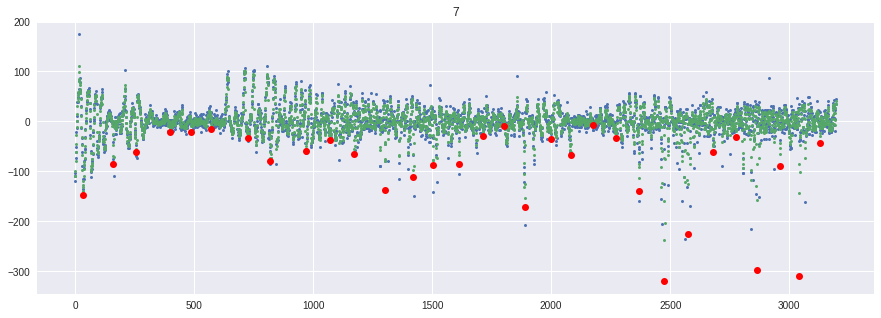

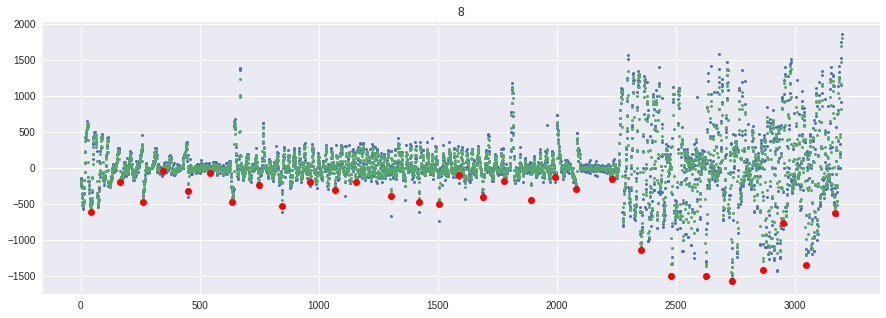

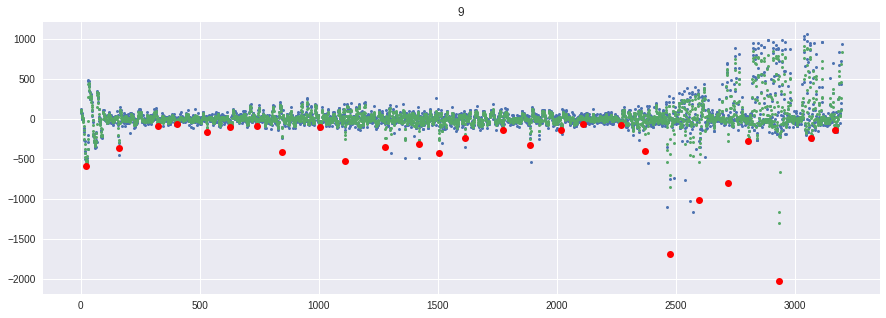

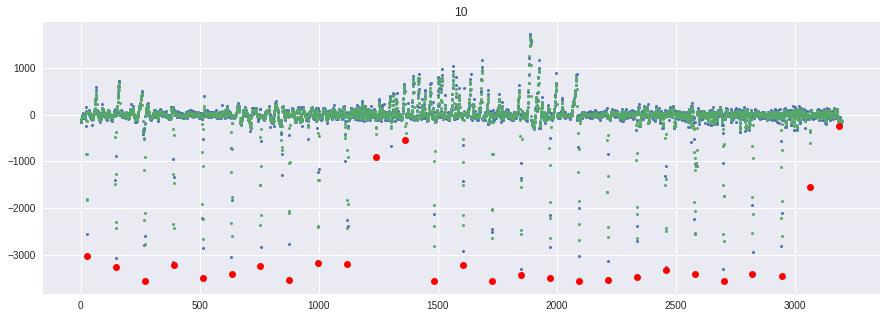

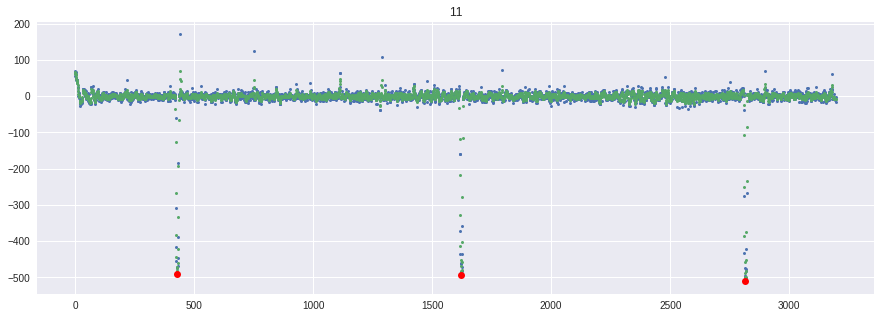

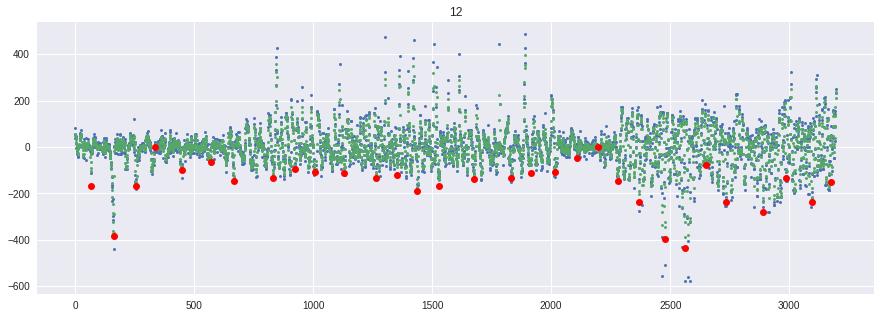

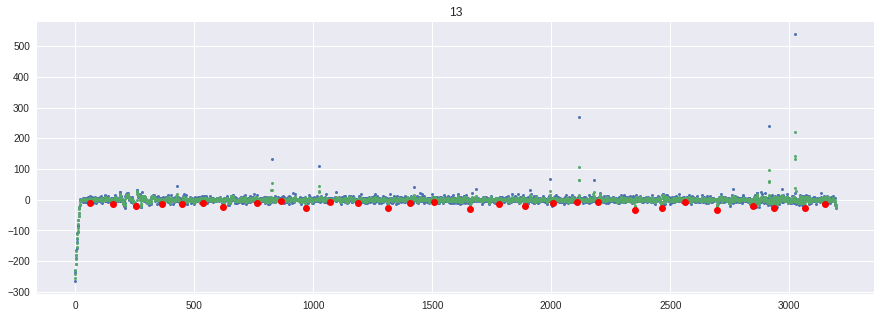

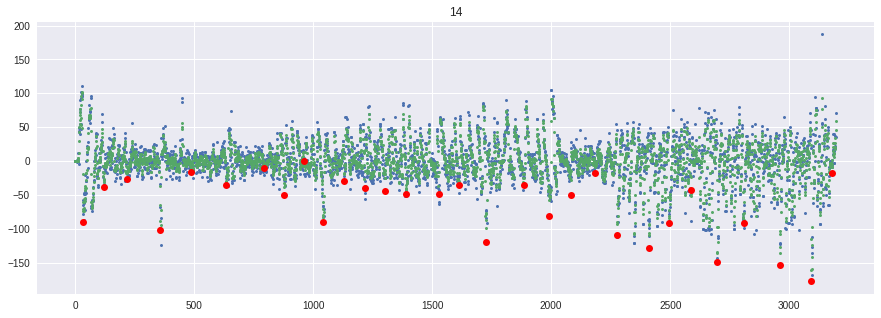

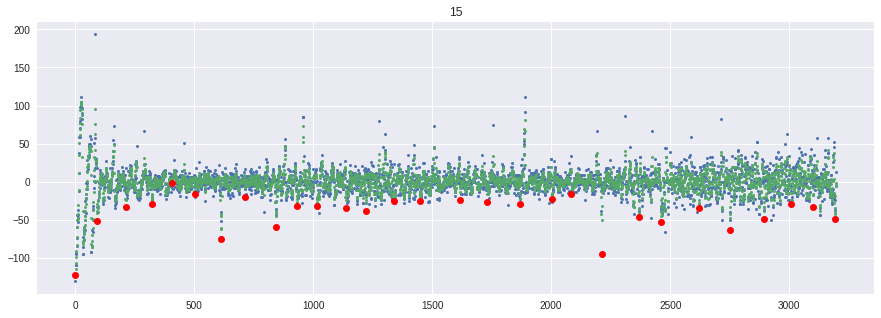

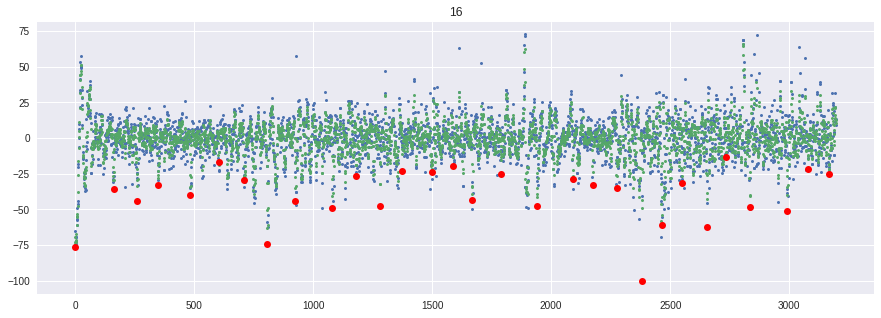

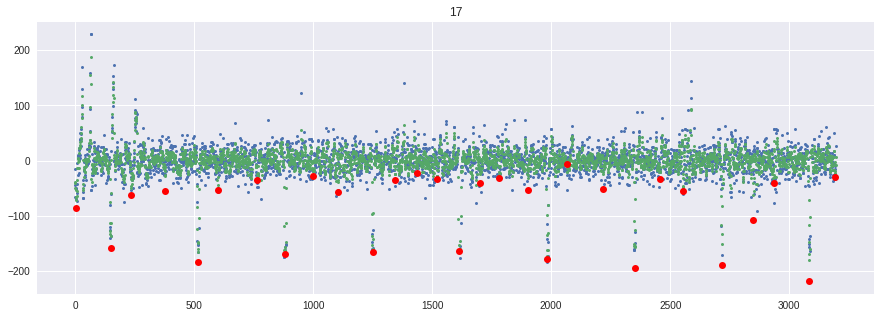

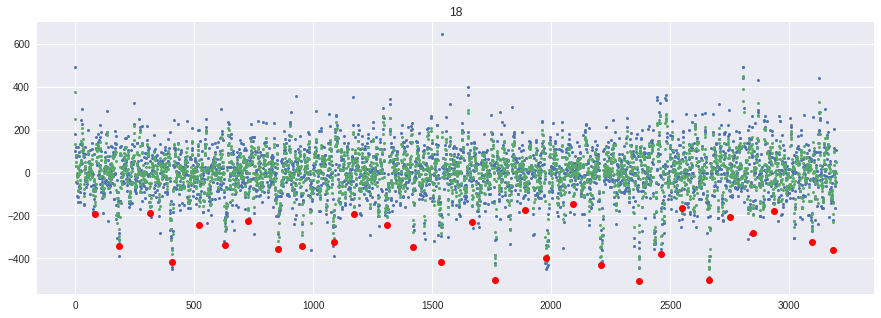

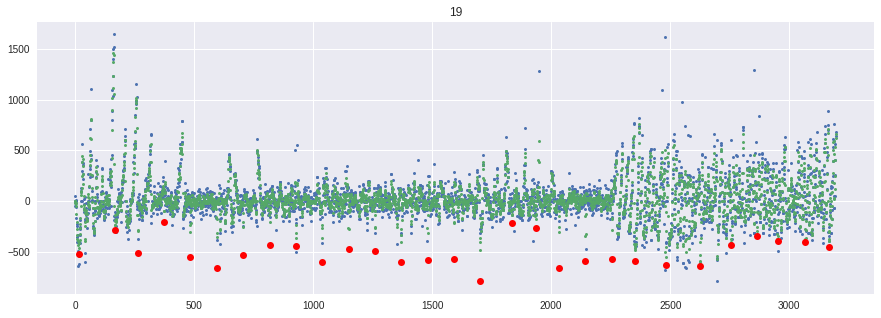

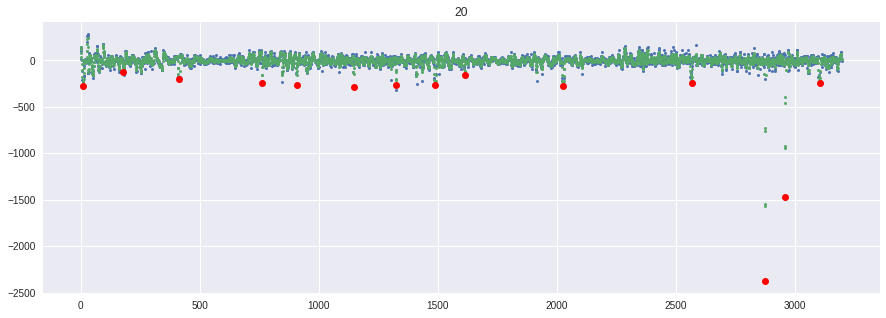

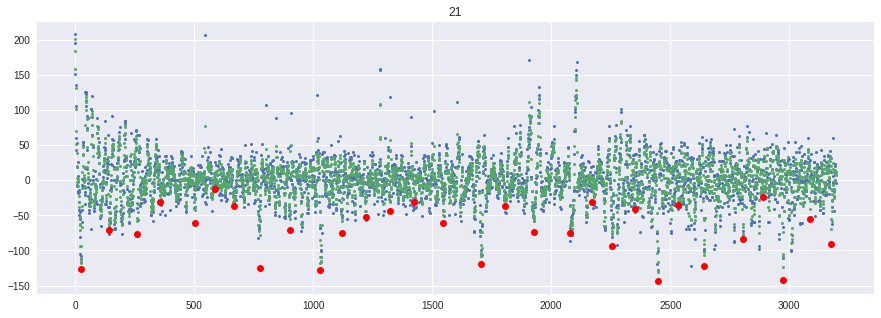

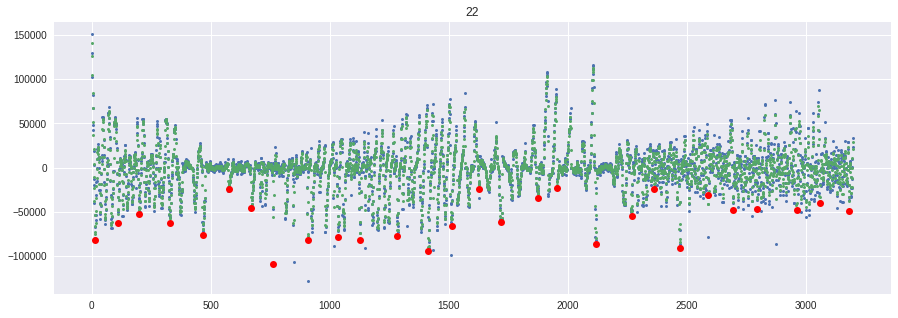

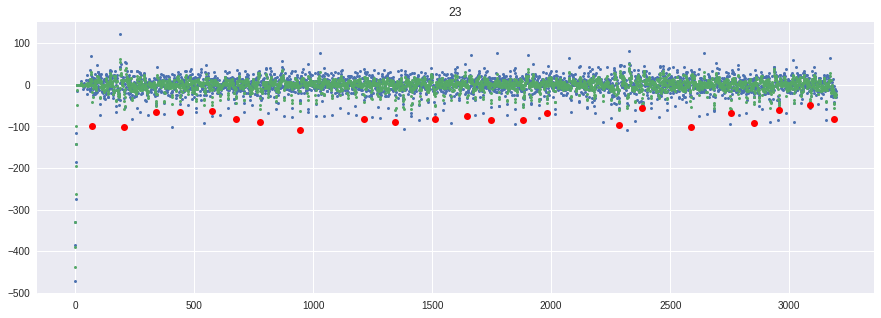

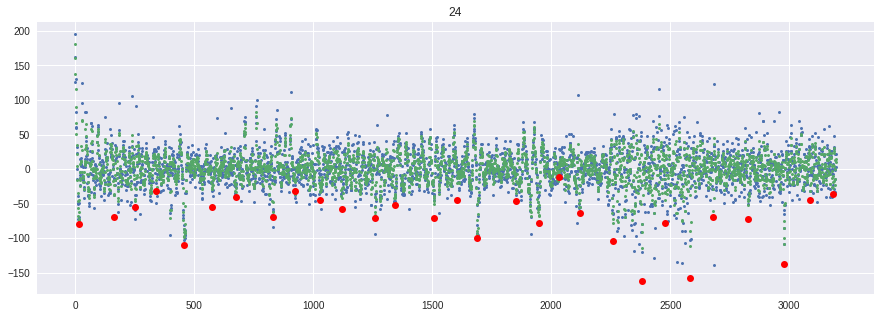

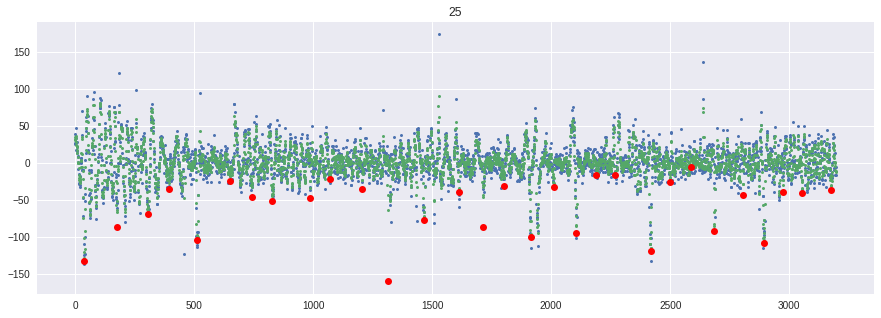

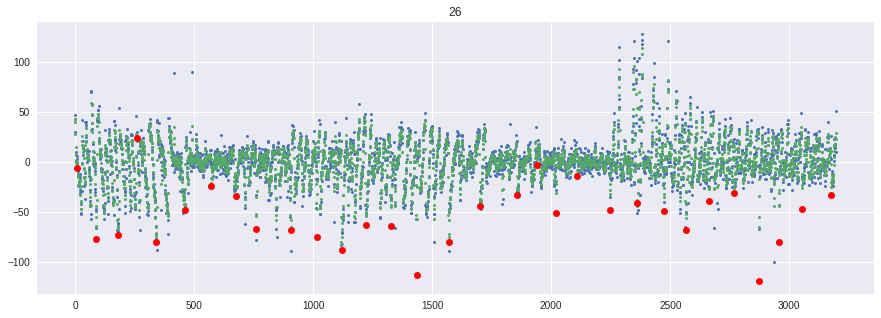

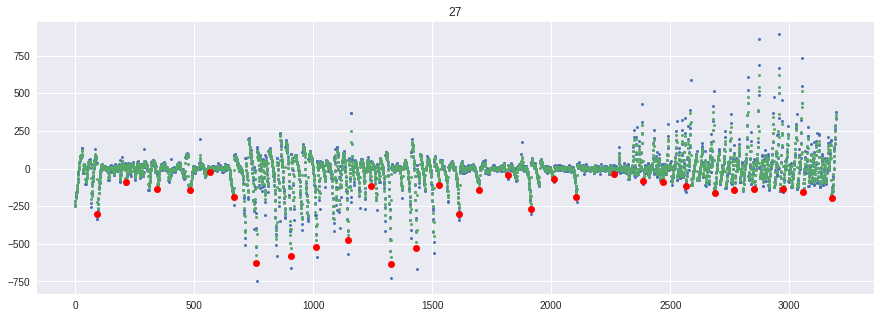

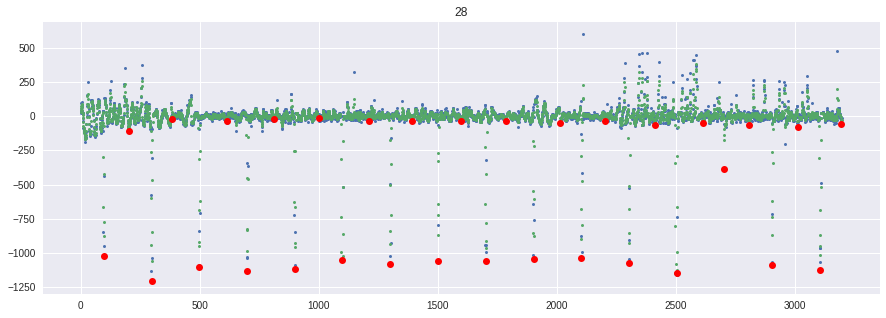

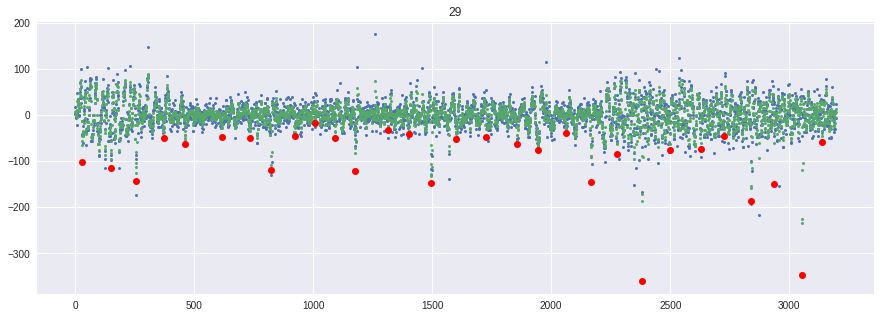

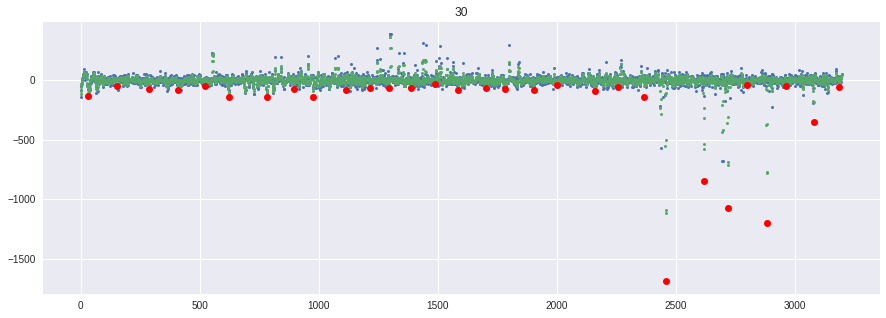

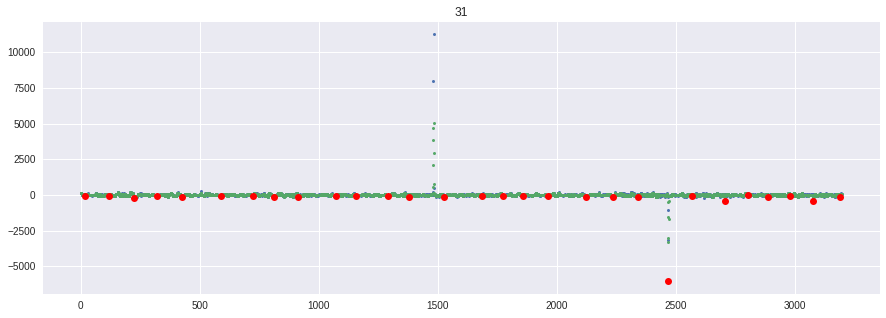

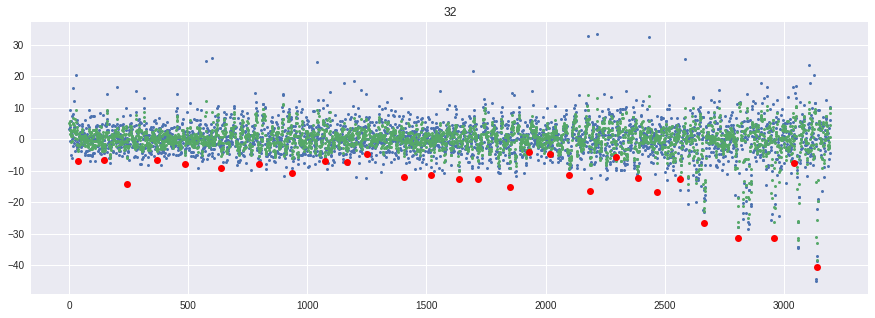

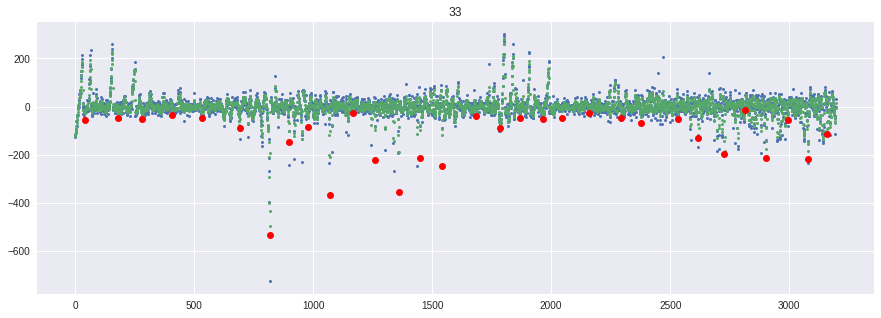

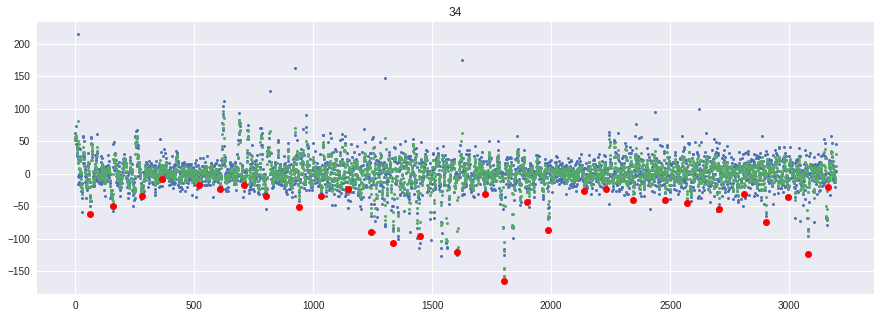

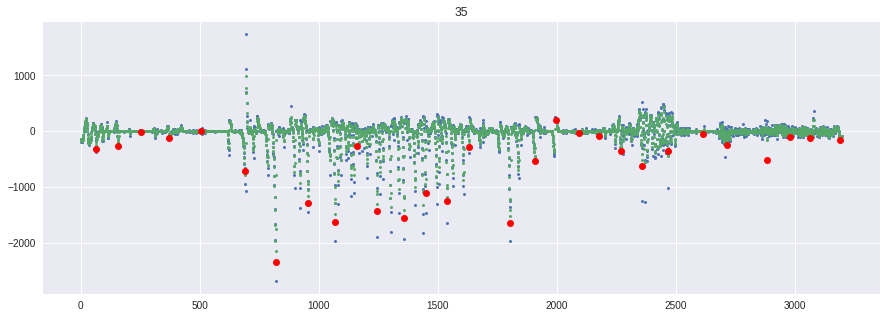

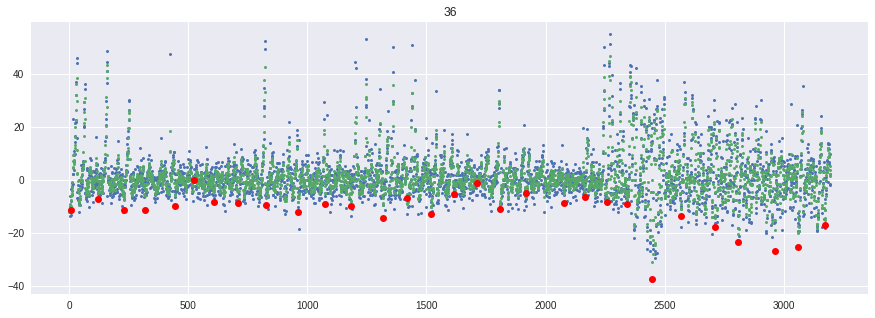

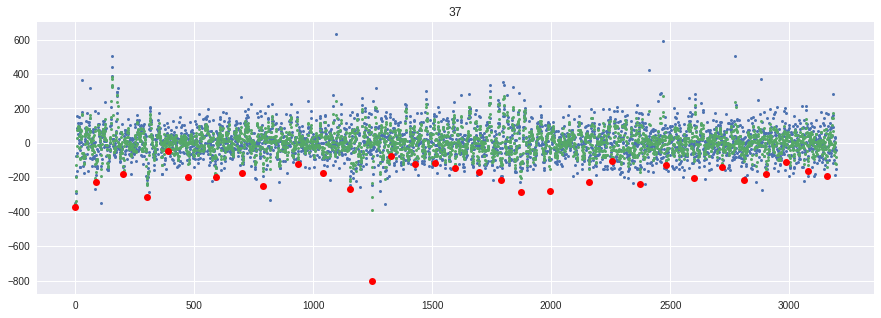

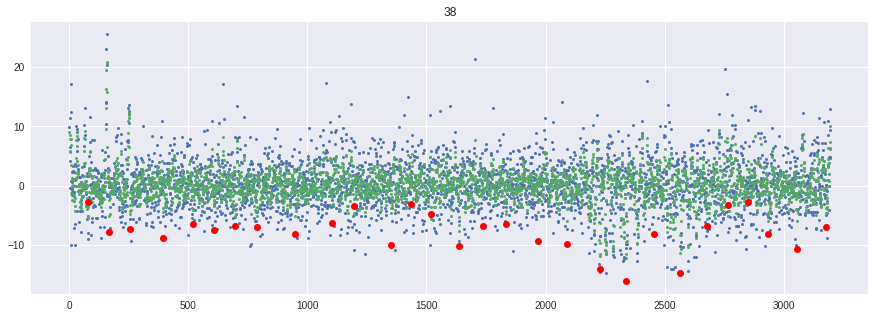

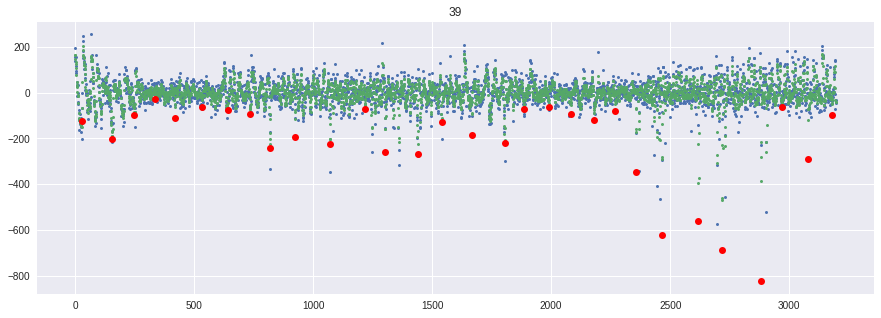

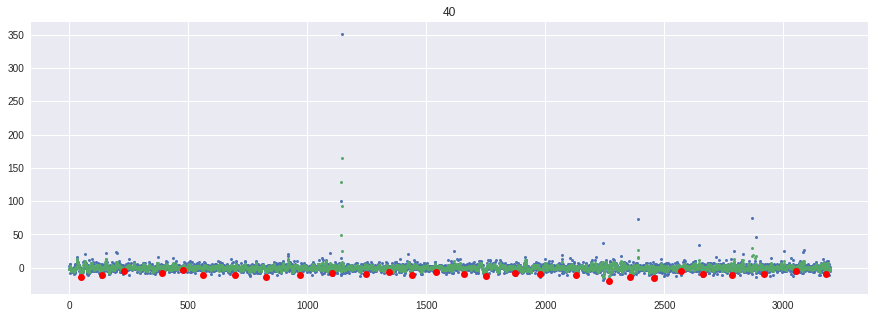

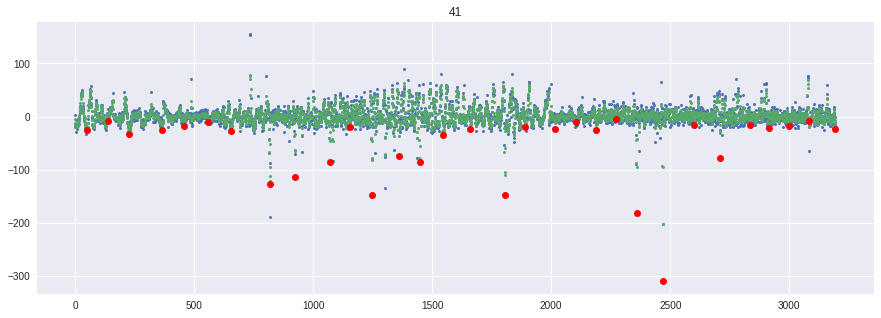

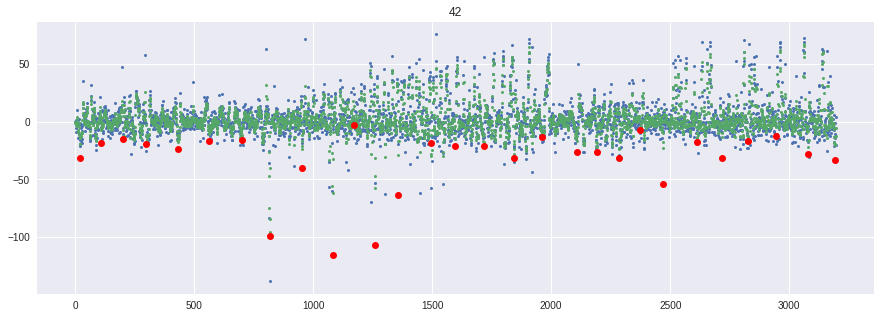

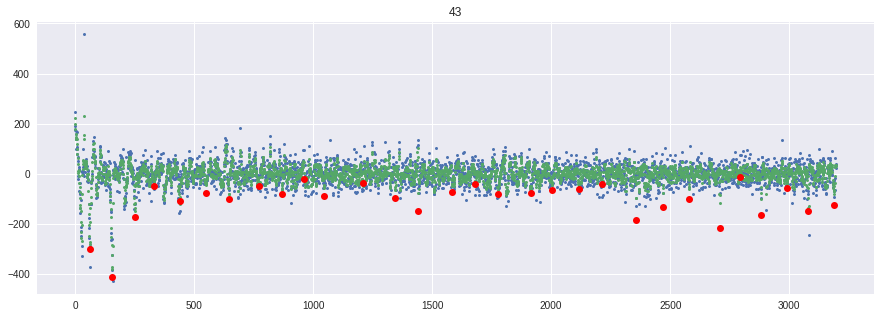

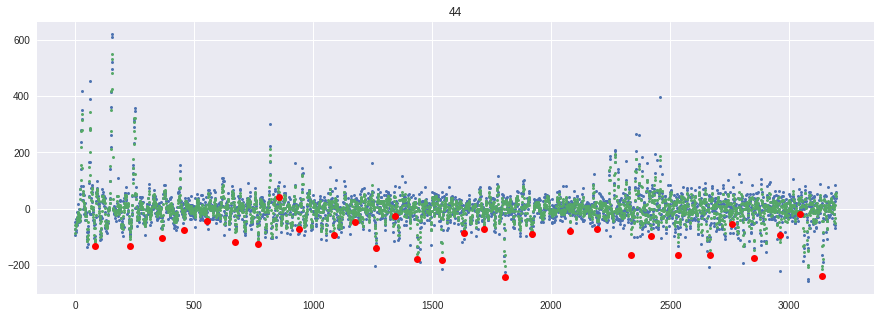

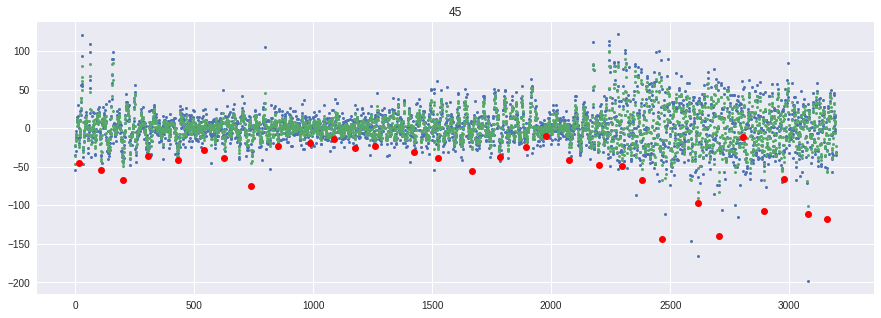

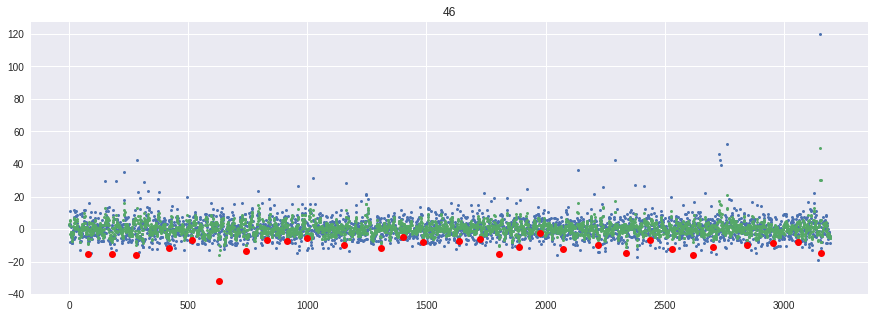

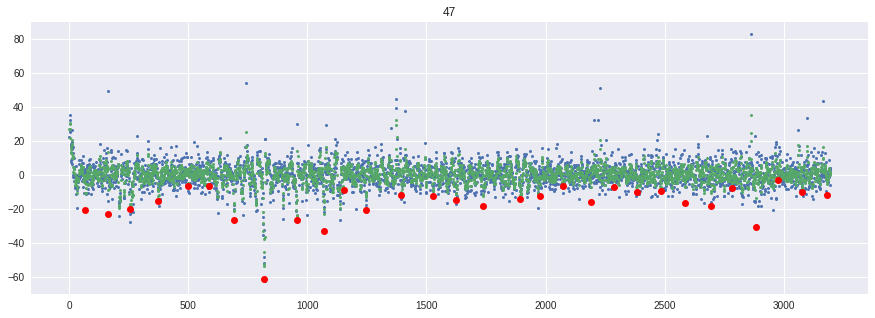

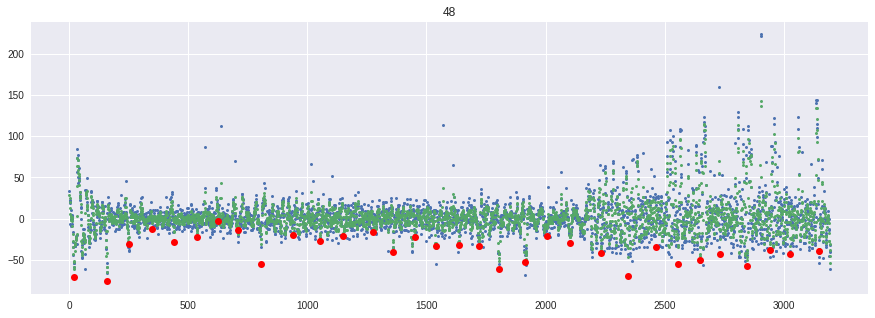

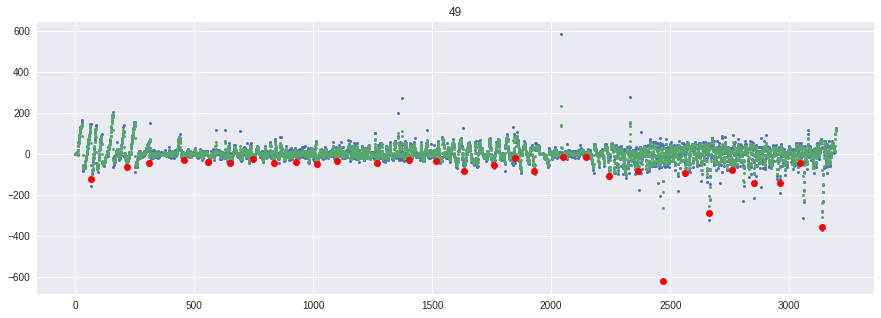

In [136]:
for i in range(50):
    plot_peaks(i)

In [9]:
PEAK_FEATURES_SIZE = 18
def peak_features(X):
    """
    Generates peak features
    """
    final_features = np.empty([len(X), PEAK_FEATURES_SIZE])

    def find_peaks(smooth):
        peaks = find_peaks_cwt(-smooth, np.arange(1, 100))
        return peaks

    def smoothen(data):
        return savgol_filter(data, polyorder=5, window_length=35)

    def dist_time(data):
        dist = data - np.roll(data, shift=-1)
        return np.mean(dist), np.std(dist)

    for idx, data in enumerate(X):
        smooth = smoothen(data)
        peaks = find_peaks(smooth)
        features = np.empty(PEAK_FEATURES_SIZE)

        std1, mean = np.std(smooth), np.mean(smooth)
        std2, std3 = 2 * std1, 3 * std1
        min1 = np.where(smooth < (mean - std1))
        min2 = np.where(smooth < (mean - std2))
        min3 = np.where(smooth < (mean - std3))
        min01 = np.where(np.logical_and(smooth > (mean - std1), smooth < mean))
        min12 = np.where(np.logical_and(smooth < (mean - std1), smooth > (mean - std2)))
        min23 = np.where(np.logical_and(smooth < (mean - std2), smooth > (mean - std3)))

        # Compute the features
        features[0], features[1], features[2] = len(min1), len(min2), len(min3)
        features[3], features[4], features[5] = len(min01), len(min12), len(min23)
        features[6], features[7] = dist_time(min1)
        features[8], features[9] = dist_time(min2)
        features[10], features[11] = dist_time(min3)
        features[12], features[13] = dist_time(min1)
        features[14], features[15] = dist_time(min2)
        features[16], features[17] = dist_time(min3)

        final_features[idx] = features

    return final_features
